In [65]:
# uv pip install lightgbm --python 3.12

In [66]:
# uv pip install optuna --python 3.12

임포트 분리

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
# import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 기록장 초기화
experiment_log = pd.DataFrame(columns=['Model_Name', 'Scale_Pos_Weight', 'Threshold', 'AUC', 'Precision', 'Recall', 'F1_Score'])

In [68]:
coc_df = pd.read_csv('C:/Users/tw2ps/Desktop/sparta_python/ML-Team_Project/coc_clans_dataset.csv')

In [69]:
coc_df_clean = coc_df.copy()

In [70]:
columns_to_drop = [
    'clan_name',
    'clan_description',
    'clan_location',
    'clan_badge_url'
]

coc_df_clean = coc_df_clean.drop(columns=columns_to_drop, errors='ignore')

print(f"제거된 컬럼: {columns_to_drop}")
print(f"남은 컬럼 수: {len(coc_df_clean.columns)}개")

제거된 컬럼: ['clan_name', 'clan_description', 'clan_location', 'clan_badge_url']
남은 컬럼 수: 23개


In [71]:
#총 전쟁 횟수
coc_df_clean['war_total'] = (
    coc_df_clean['war_wins'] + 
    coc_df_clean['war_ties'] + 
    coc_df_clean['war_losses']
)

#승률
coc_df_clean['win_rate'] = coc_df_clean.apply(
    lambda row: row['war_wins'] / row['war_total'] if row['war_total'] > 0 else 0,
    axis=1
)

#확인
print("파생변수 생성 완료:")
coc_df_clean[['clan_tag', 'war_wins', 'war_total', 'win_rate']].head()

파생변수 생성 완료:


,clan_tag,war_wins,war_total,win_rate
0,#UQVQRJQ0,93,124,0.750000
1,#2QC9Y0CQU,0,0,0.000000
2,#202CJRP2U,1,1,1.000000
3,#2Y89RRGLY,7,18,0.388889
4,#99PU9QPY,3,14,0.214286


In [72]:
# 두 컬럼 비교
comparison_result = (coc_df_clean['required_builder_base_trophies'] == coc_df_clean['required_versus_trophies']).all()

print(f"완전히 동일한가요?: {comparison_result}")

# 차이가 있다면 얼마나 다른지 확인 (샘플 보기)
if not comparison_result:
    diff_df = coc_df_clean[coc_df_clean['clan_builder_base_points'] != coc_df_clean['clan_versus_points']]
    print(f"\n차이가 있는 행 개수: {len(diff_df)}개")
    print(diff_df[['clan_builder_base_points', 'clan_versus_points']].head())
else:
    print("\n두 컬럼은 완벽하게 일치합니다. 하나는 삭제해도 됩니다.")

완전히 동일한가요?: True

두 컬럼은 완벽하게 일치합니다. 하나는 삭제해도 됩니다.


In [73]:
comparison_result = (coc_df_clean['clan_builder_base_points'] == coc_df_clean['clan_versus_points']).all()

print(f"완전히 동일한가요?: {comparison_result}")

# 차이가 있다면 얼마나 다른지 확인 (샘플 보기)
if not comparison_result:
    diff_df = coc_df_clean[coc_df_clean['clan_builder_base_points'] != coc_df_clean['clan_versus_points']]
    print(f"\n차이가 있는 행 개수: {len(diff_df)}개")
    print(diff_df[['clan_builder_base_points', 'clan_versus_points']].head())
else:
    print("\n두 컬럼은 완벽하게 일치합니다. 하나는 삭제해도 됩니다.")

완전히 동일한가요?: True

두 컬럼은 완벽하게 일치합니다. 하나는 삭제해도 됩니다.


In [74]:
# 비활성 클랜 조건 정의
# 조건 1: 멤버 5명 미만 (클랜전 최소 인원 미달)
# 조건 2: 레벨 2 이상인데 캐피탈 점수가 0 (과거엔 활동했으나 현재 중단)
# 조건 3: 전쟁 경험이 0 

def is_ghost(row):
    # 멤버 5명 미만 -> 전쟁 자체가 불가능함
    if row['num_members'] < 5:
        return True
    # 레벨은 2 이상인데 캐피탈 점수가 0 → 활동 중단
    if row['clan_level'] >= 2 and row['clan_capital_points'] == 0:
        return True
    # 전쟁 경험 없음 → 분석 불가
    if row['war_total'] == 0:
        return True
    return False

# 비활성 클랜 여부 컬럼 생성
coc_df_clean['is_ghost'] = coc_df_clean.apply(is_ghost, axis=1)

# 비활성 클랜 비율 확인
ghost_count = coc_df_clean['is_ghost'].sum()
total_count = len(coc_df_clean)
print(f"유령 클랜 수: {ghost_count:,}개 ({ghost_count/total_count*100:.1f}%)")
print(f"정상 클랜 수: {total_count - ghost_count:,}개")

# 정상 클랜만 남기기 (is_ghost == False)
coc_df_active = coc_df_clean[coc_df_clean['is_ghost'] == False].copy()

print(f"\n분석용 데이터(coc_df_active) 생성 완료: {len(coc_df_active):,}개 클랜")

유령 클랜 수: 3,222,737개 (90.5%)
정상 클랜 수: 337,006개

분석용 데이터(coc_df_active) 생성 완료: 337,006개 클랜


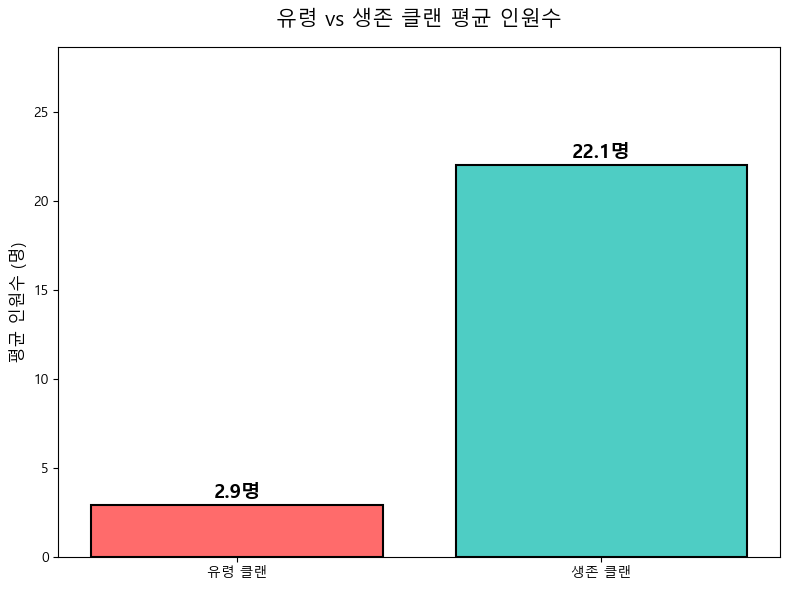

In [75]:
# ==========================================
# [시각화] 유령 클랜 vs 생존 클랜 평균 인원수 비교
# ==========================================

# 1. 유령/생존 클랜 분리
ghost_clans = coc_df_clean[coc_df_clean['is_ghost'] == True]
active_clans = coc_df_clean[coc_df_clean['is_ghost'] == False]

# 2. 평균 인원수 계산
ghost_avg = ghost_clans['num_members'].mean()
active_avg = active_clans['num_members'].mean()

# 3. 막대 그래프
plt.figure(figsize=(8, 6))

categories = ['유령 클랜', '생존 클랜']
averages = [ghost_avg, active_avg]
colors = ['#ff6b6b', '#4ecdc4']

bars = plt.bar(categories, averages, color=colors, edgecolor='black', linewidth=1.5)
plt.title('유령 vs 생존 클랜 평균 인원수', fontsize=15, pad=15)
plt.ylabel('평균 인원수 (명)', fontsize=12)
plt.ylim(0, max(averages) * 1.3)

# 막대 위에 숫자 표시
for bar, avg in zip(bars, averages):
    height = bar.get_height()
    plt.annotate(f'{avg:.1f}명',
                 xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 5), textcoords="offset points",
                 ha='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [76]:
# isFamilyFriendly: True -> 1, False -> 0
coc_df_active['isFamilyFriendly'] = coc_df_active['isFamilyFriendly'].astype(int)

# 확인
print("인코딩 완료!")
print(coc_df_active['isFamilyFriendly'].value_counts())

인코딩 완료!
isFamilyFriendly
0    197299
1    139707
Name: count, dtype: int64


In [77]:
# 최종 데이터 구조 확인
print("=" * 50)
print("전처리 완료 데이터 (coc_df_active) 정보")
print("=" * 50)
coc_df_active.info()

전처리 완료 데이터 (coc_df_active) 정보
<class 'pandas.core.frame.DataFrame'>
Index: 337006 entries, 11 to 3559705
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   clan_tag                        337006 non-null  object 
 1   clan_type                       337006 non-null  object 
 2   isFamilyFriendly                337006 non-null  int64  
 3   clan_level                      337006 non-null  int64  
 4   clan_points                     337006 non-null  int64  
 5   clan_builder_base_points        337006 non-null  int64  
 6   clan_versus_points              337006 non-null  int64  
 7   required_trophies               337006 non-null  int64  
 8   war_frequency                   337006 non-null  object 
 9   war_win_streak                  337006 non-null  int64  
 10  war_wins                        337006 non-null  int64  
 11  war_ties                        337006 non-null  in

In [78]:
# 수치형 데이터 기초 통계
coc_df_active.describe()

,isFamilyFriendly,clan_level,clan_points,clan_builder_base_points,clan_versus_points,required_trophies,war_win_streak,war_wins,war_ties,war_losses,num_members,required_builder_base_trophies,required_versus_trophies,required_townhall_level,clan_capital_hall_level,clan_capital_points,mean_member_level,mean_member_trophies,war_total,win_rate
count,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000,337006.000000
mean,0.414553,7.437992,14932.318205,14927.407746,14927.407746,827.705554,0.778170,92.038486,0.706714,43.008032,22.065812,495.614265,495.614265,5.500691,3.812653,717.001279,92.816861,1691.458873,135.753233,0.563210
std,0.492646,7.023098,12591.352375,12097.967308,12097.967308,1183.228381,2.014885,147.210244,2.854366,91.297694,15.696935,998.449221,998.449221,4.607779,3.368117,968.783918,52.079004,940.432216,210.231000,0.309922
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,1.000000,3399.000000,3548.000000,3548.000000,0.000000,0.000000,2.000000,0.000000,1.000000,7.000000,0.000000,0.000000,1.000000,0.000000,0.000000,51.000000,930.000000,6.000000,0.363636
50%,0.000000,5.000000,11728.000000,12881.000000,12881.000000,200.000000,0.000000,21.000000,0.000000,5.000000,18.000000,0.000000,0.000000,4.000000,3.000000,222.000000,90.000000,1566.000000,37.000000,0.536232
75%,1.000000,12.000000,24067.000000,24267.750000,24267.750000,1400.000000,1.000000,118.000000,0.000000,34.000000,37.000000,600.000000,600.000000,10.000000,7.000000,1198.000000,128.000000,2285.000000,177.000000,0.800000
max,1.000000,36.000000,54721.000000,51686.000000,51686.000000,5500.000000,261.000000,1565.000000,266.000000,1220.000000,50.000000,5500.000000,5500.000000,15.000000,10.000000,5866.000000,292.000000,5466.000000,1565.000000,1.000000


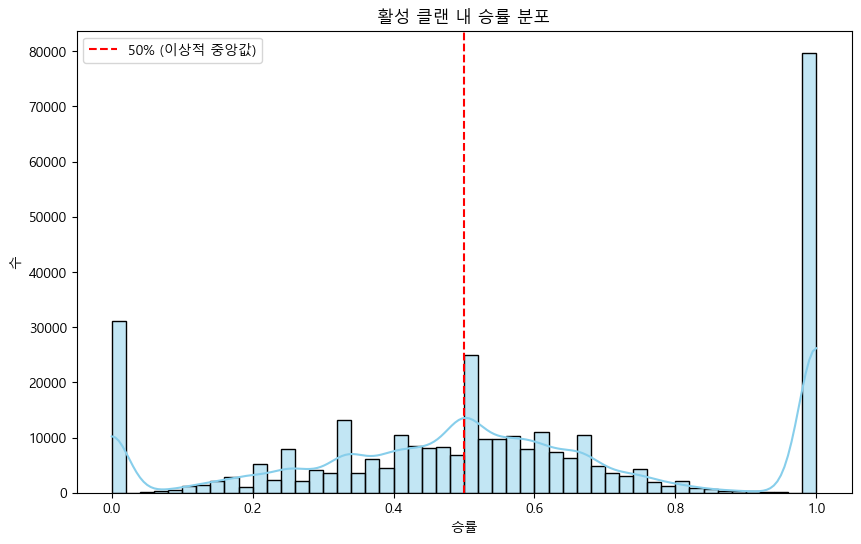

평균 승률: 56.32%
중앙값 승률: 53.62%


In [79]:
# 승률 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(coc_df_active['win_rate'], bins=50, kde=True, color='skyblue')
plt.axvline(x=0.5, color='red', linestyle='--', label='50% (이상적 중앙값)')
plt.title('활성 클랜 내 승률 분포')
plt.xlabel('승률')
plt.ylabel('수')
plt.legend()
plt.show()

# 기초 통계
print(f"평균 승률: {coc_df_active['win_rate'].mean():.2%}")
print(f"중앙값 승률: {coc_df_active['win_rate'].median():.2%}")

100% 승률 클랜 수: 79,735개

전쟁 횟수 통계:
count    79735.000000
mean       176.995648
std        187.994378
min          1.000000
25%         20.000000
50%        114.000000
75%        280.000000
max       1565.000000
Name: war_total, dtype: float64


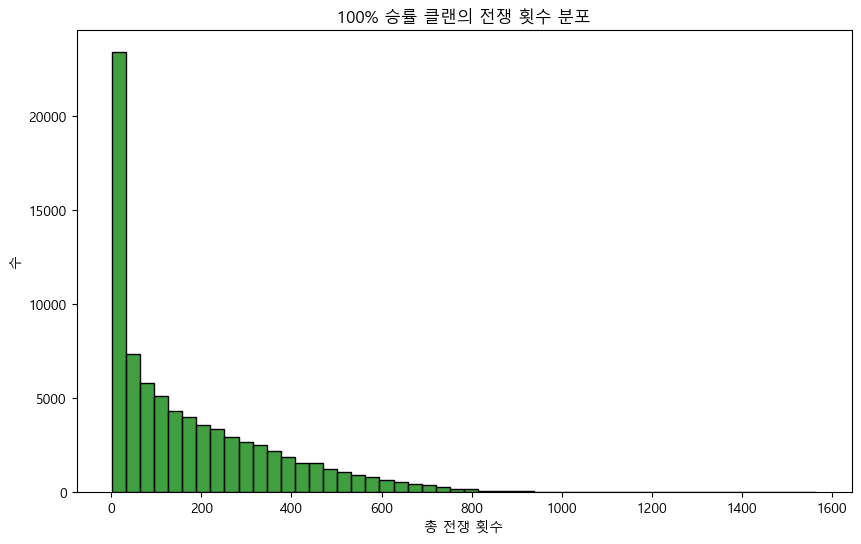


1~3판만 하고 100%인 클랜: 12,898개 (16.2%)


In [80]:
# 100% 승률 클랜만 필터링
perfect_clans = coc_df_active[coc_df_active['win_rate'] == 1.0]

# 전쟁 횟수 분포 확인
print(f"100% 승률 클랜 수: {len(perfect_clans):,}개")
print(f"\n전쟁 횟수 통계:")
print(perfect_clans['war_total'].describe())

# 시각화
plt.figure(figsize=(10, 6))
sns.histplot(perfect_clans['war_total'], bins=50, color='green')
plt.title('100% 승률 클랜의 전쟁 횟수 분포')
plt.xlabel('총 전쟁 횟수')
plt.ylabel('수')
plt.show()

# 1~3판만 한 클랜 비율 확인
few_wars = perfect_clans[perfect_clans['war_total'] <= 3]
print(f"\n1~3판만 하고 100%인 클랜: {len(few_wars):,}개 ({len(few_wars)/len(perfect_clans)*100:.1f}%)")

In [81]:
# 20판 이상 클랜만 필터링 (Q1 기반)
MIN_WARS = 20
coc_df_reliable = coc_df_active[coc_df_active['war_total'] >= MIN_WARS].copy()

print(f"기준: {MIN_WARS}판 이상")
print(f"전체: {len(coc_df_active):,}개 → 필터 후: {len(coc_df_reliable):,}개")
print(f"제외: {len(coc_df_active) - len(coc_df_reliable):,}개 ({(len(coc_df_active) - len(coc_df_reliable))/len(coc_df_active)*100:.1f}%)")

기준: 20판 이상
전체: 337,006개 → 필터 후: 197,861개
제외: 139,145개 (41.3%)


기준: 20판 이상
전체: 337,006개 → 필터 후: 197,861개


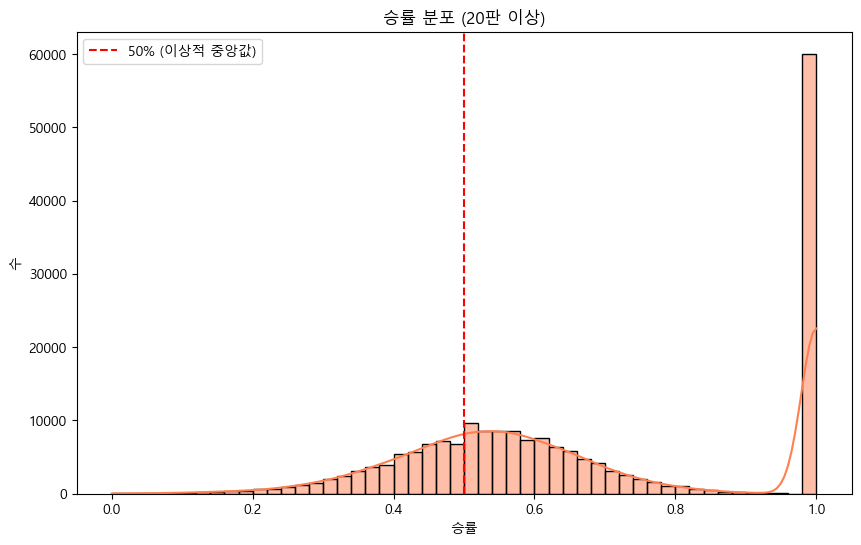


평균 승률: 67.21%
중앙값 승률: 60.61%


In [82]:
# 20판 이상 클랜만 필터링
MIN_WARS = 20
coc_df_reliable = coc_df_active[coc_df_active['war_total'] >= MIN_WARS].copy()

print(f"기준: {MIN_WARS}판 이상")
print(f"전체: {len(coc_df_active):,}개 → 필터 후: {len(coc_df_reliable):,}개")

# 승률 분포 재시각화
plt.figure(figsize=(10, 6))
sns.histplot(coc_df_reliable['win_rate'], bins=50, kde=True, color='coral')
plt.axvline(x=0.5, color='red', linestyle='--', label='50% (이상적 중앙값)')
plt.title(f'승률 분포 ({MIN_WARS}판 이상)')
plt.xlabel('승률')
plt.ylabel('수')
plt.legend()
plt.show()

# 기초 통계
print(f"\n평균 승률: {coc_df_reliable['win_rate'].mean():.2%}")
print(f"중앙값 승률: {coc_df_reliable['win_rate'].median():.2%}")

In [83]:
# 20판 이상 + 100% 승률 클랜 추출
perfect_elite = coc_df_reliable[coc_df_reliable['win_rate'] == 1.0]

print(f"20판 이상 100% 승률 클랜: {len(perfect_elite):,}개")
print("=" * 50)

# 주요 지표 확인
print("\n[기본 스펙]")
print(perfect_elite[['clan_level', 'clan_points', 'num_members', 'war_total']].describe())

print("\n[전쟁 리그 등급 분포]")
print(perfect_elite['clan_war_league'].value_counts())

print("\n[캐피탈 홀 레벨 분포]")
print(perfect_elite['clan_capital_hall_level'].value_counts().sort_index())

# 일반 클랜과 비교
normal_clans = coc_df_reliable[(coc_df_reliable['win_rate'] >= 0.4) & (coc_df_reliable['win_rate'] <= 0.6)]

print("\n" + "=" * 50)
print("[비교: 100% 승률 vs 일반 클랜(40~60%)]")
print(f"평균 클랜 레벨 - 100%: {perfect_elite['clan_level'].mean():.1f} / 일반: {normal_clans['clan_level'].mean():.1f}")
print(f"평균 멤버 수 - 100%: {perfect_elite['num_members'].mean():.1f} / 일반: {normal_clans['num_members'].mean():.1f}")
print(f"평균 캐피탈 - 100%: {perfect_elite['clan_capital_hall_level'].mean():.1f} / 일반: {normal_clans['clan_capital_hall_level'].mean():.1f}")

20판 이상 100% 승률 클랜: 60,043개

[기본 스펙]
         clan_level  clan_points   num_members     war_total
count  60043.000000  60043.00000  60043.000000  60043.000000
mean      15.133105  26717.03211     33.822377    233.528205
std        5.932504  11158.40633     13.055108    184.346770
min        1.000000    512.00000      5.000000     20.000000
25%       10.000000  17992.50000     23.000000     84.000000
50%       15.000000  27266.00000     37.000000    185.000000
75%       20.000000  35761.00000     46.000000    339.000000
max       36.000000  54721.00000     50.000000   1565.000000

[전쟁 리그 등급 분포]
clan_war_league
Crystal League I       9056
Crystal League II      7645
Crystal League III     6912
Gold League I          6521
Gold League II         6011
Master League III      5463
Gold League III        4650
Silver League I        2981
Master League II       2939
Unranked               2241
Silver League II       1687
Master League I        1515
Silver League III       987
Champion League III 

In [84]:
# 전체 대비 비율
reliable_total = len(coc_df_reliable)
perfect_count = len(perfect_elite)

print(f"20판 이상 전체 클랜: {reliable_total:,}개")
print(f"100% 승률 클랜: {perfect_count:,}개")
print(f"비율: {perfect_count/reliable_total*100:.1f}%")

20판 이상 전체 클랜: 197,861개
100% 승률 클랜: 60,043개
비율: 30.3%


In [85]:
# 전쟁 리그 분포 확인
print("전쟁 리그 등급 분포:")
print(coc_df_reliable['clan_war_league'].value_counts())

# 리그별 클랜 특성 비교
league_stats = coc_df_reliable.groupby('clan_war_league').agg({
    'clan_level': 'mean',
    'clan_points': 'mean',
    'num_members': 'mean',
    'clan_capital_hall_level': 'mean'
}).round(1)

print("\n리그별 평균 스펙:")
display(league_stats)

전쟁 리그 등급 분포:
clan_war_league
Gold League II         23018
Gold League III        22892
Gold League I          20897
Crystal League III     18987
Silver League I        18662
Crystal League I       18550
Crystal League II      17831
Unranked               15508
Silver League II       12425
Master League III       9992
Silver League III       7407
Master League II        5126
Master League I         2508
Bronze League I         1614
Champion League III     1138
Champion League II       481
Champion League I        369
Bronze League II         361
Bronze League III         95
Name: count, dtype: int64

리그별 평균 스펙:


,clan_level,clan_points,num_members,clan_capital_hall_level
clan_war_league,,,,
Bronze League I,5.9,9663.8,21.5,3.3
Bronze League II,5.9,9001.3,20.4,2.9
Bronze League III,5.1,7086.8,19.5,2.5
Champion League I,22.4,30594.6,27.7,9.4
Champion League II,22.5,35559.1,31.2,9.3
Champion League III,22.6,38168.9,34.1,9.5
Crystal League I,18.3,34423.2,39.6,8.7
Crystal League II,16.0,30533.7,37.9,7.9
Crystal League III,13.9,26838.2,36.2,7.1


In [86]:
# 가입 유형별 평균 스펙
type_stats = coc_df_reliable.groupby('clan_type').agg({
    'clan_level': 'mean',
    'clan_points': 'mean',
    'num_members': 'mean',
    'clan_capital_hall_level': 'mean',
    'mean_member_trophies': 'mean'
}).round(1)

print("클랜 가입 유형별 평균 스펙:")
display(type_stats)

클랜 가입 유형별 평균 스펙:


,clan_level,clan_points,num_members,clan_capital_hall_level,mean_member_trophies
clan_type,,,,,
closed,13.0,22219.0,28.6,6.2,2298.0
inviteOnly,13.0,23798.2,30.1,6.4,2371.6
open,10.1,20696.2,31.4,5.7,2053.6


In [87]:
# 가족 친화 여부별 평균 스펙
family_stats = coc_df_reliable.groupby('isFamilyFriendly').agg({
    'clan_level': 'mean',
    'clan_points': 'mean',
    'num_members': 'mean',
    'clan_capital_hall_level': 'mean',
    'mean_member_trophies': 'mean'
}).round(1)

print("가족 친화 여부별 평균 스펙:")
display(family_stats)

가족 친화 여부별 평균 스펙:


,clan_level,clan_points,num_members,clan_capital_hall_level,mean_member_trophies
isFamilyFriendly,,,,,
0,12.0,22410.8,30.1,6.1,2259.5
1,11.2,21945.2,31.3,6.0,2160.9


In [88]:
# 예시: 클랜 레벨 구간별로 나눠서 분석
coc_df_reliable['level_group'] = pd.cut(
    coc_df_reliable['clan_level'],
    bins=[0, 5, 10, 15, 20, 40],
    labels=['1-5', '6-10', '11-15', '16-20', '21+']
)

level_stats = coc_df_reliable.groupby('level_group', observed=True).agg({
    'clan_points': 'mean',
    'clan_capital_points': 'mean',
    'mean_member_trophies': 'mean'
}).round(0)

print("클랜 레벨 구간별 스펙:")
display(level_stats)

클랜 레벨 구간별 스펙:


,clan_points,clan_capital_points,mean_member_trophies
level_group,,,
1-5,10554.0,347.0,1424.0
6-10,17641.0,788.0,1861.0
11-15,24452.0,1289.0,2343.0
16-20,31048.0,1814.0,2840.0
21+,37400.0,2494.0,3387.0


요구 트로피 구간별 평균 캐피탈 점수:


,mean,median,count
trophy_req_group,,,
0-1k,883.0,615.0,109551
1k-2k,1337.0,1244.0,49930
2k-3k,1771.0,1762.0,22166
3k-4k,2053.0,2052.0,8209
4k+,1604.0,1345.0,8005


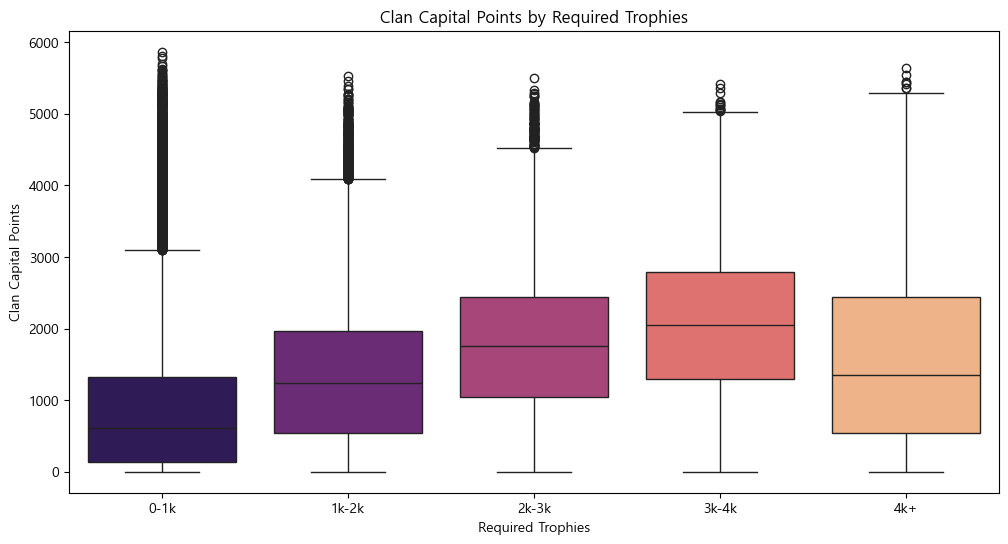

In [89]:
# 1. 요구 트로피 구간화 (0, 1000, 2000, 3000, 4000, 5000+)
bins = [0, 1000, 2000, 3000, 4000, 6000]
labels = ['0-1k', '1k-2k', '2k-3k', '3k-4k', '4k+']
coc_df_reliable['trophy_req_group'] = pd.cut(
    coc_df_reliable['required_trophies'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# 2. 구간별 평균 성과 (캐피탈 점수)
req_stats = coc_df_reliable.groupby('trophy_req_group', observed=True)['clan_capital_points'].agg(['mean', 'median', 'count']).round(0)

print("요구 트로피 구간별 평균 캐피탈 점수:")
display(req_stats)

# 3. 시각화 (Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(data=coc_df_reliable, x='trophy_req_group', y='clan_capital_points', 
            hue='trophy_req_group', palette='magma', legend=False)
plt.title('Clan Capital Points by Required Trophies')
plt.xlabel('Required Trophies')
plt.ylabel('Clan Capital Points')
plt.show()

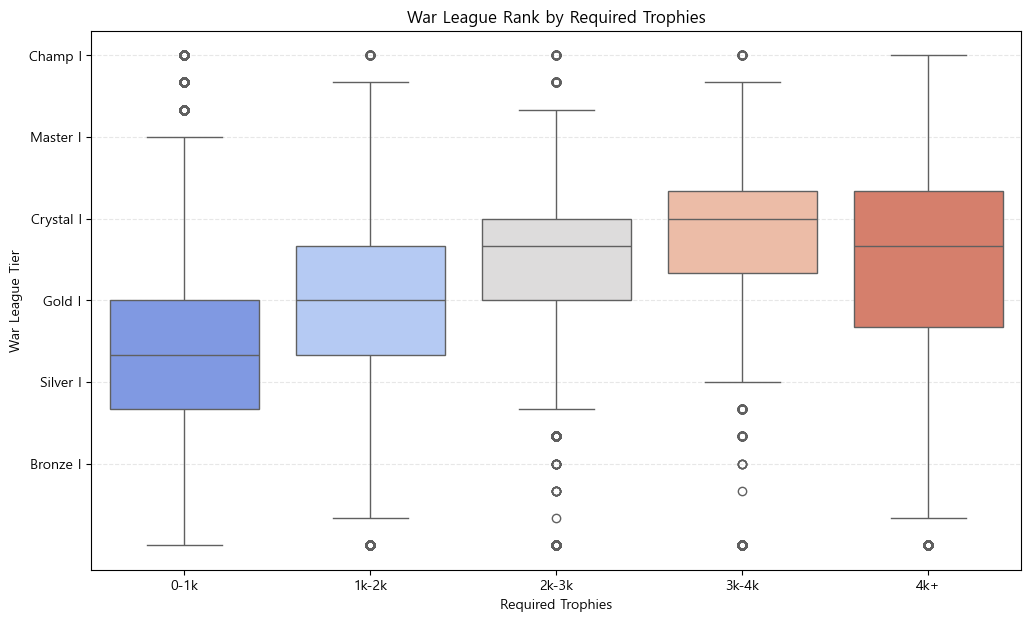

요구 트로피별 평균 리그 랭킹 (숫자):
trophy_req_group
0-1k      7.0
1k-2k     8.9
2k-3k    10.5
3k-4k    11.5
4k+      10.4
Name: league_rank, dtype: float64


In [90]:
# 1. 전쟁 리그 순서 정의 (낮은 등급 -> 높은 등급)
league_order = [
    'Unranked',
    'Bronze League III', 'Bronze League II', 'Bronze League I',
    'Silver League III', 'Silver League II', 'Silver League I',
    'Gold League III', 'Gold League II', 'Gold League I',
    'Crystal League III', 'Crystal League II', 'Crystal League I',
    'Master League III', 'Master League II', 'Master League I',
    'Champion League III', 'Champion League II', 'Champion League I'
]

# 등급을 숫자로 매핑 (Unranked=0, Bronze III=1, ... Champion I=18)
league_map = {name: i for i, name in enumerate(league_order)}
coc_df_reliable['league_rank'] = coc_df_reliable['clan_war_league'].map(league_map)

# 2. 시각화 (요구 트로피별 리그 등급 분포)
plt.figure(figsize=(12, 7))
sns.boxplot(data=coc_df_reliable, x='trophy_req_group', y='league_rank', hue='trophy_req_group', palette='coolwarm', legend=False)

# Y축을 숫자가 아닌 '리그 이름'으로 표시 (가독성 UP)
# 주요 지점(각 티어 1단계)만 표시
ytick_locs = [3, 6, 9, 12, 15, 18]
ytick_labels = ['Bronze I', 'Silver I', 'Gold I', 'Crystal I', 'Master I', 'Champ I']
plt.yticks(ytick_locs, ytick_labels)

plt.title('War League Rank by Required Trophies')
plt.xlabel('Required Trophies')
plt.ylabel('War League Tier')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

# 3. 구간별 평균 랭킹 확인
print("요구 트로피별 평균 리그 랭킹 (숫자):")
print(coc_df_reliable.groupby('trophy_req_group', observed=True)['league_rank'].mean().round(1))

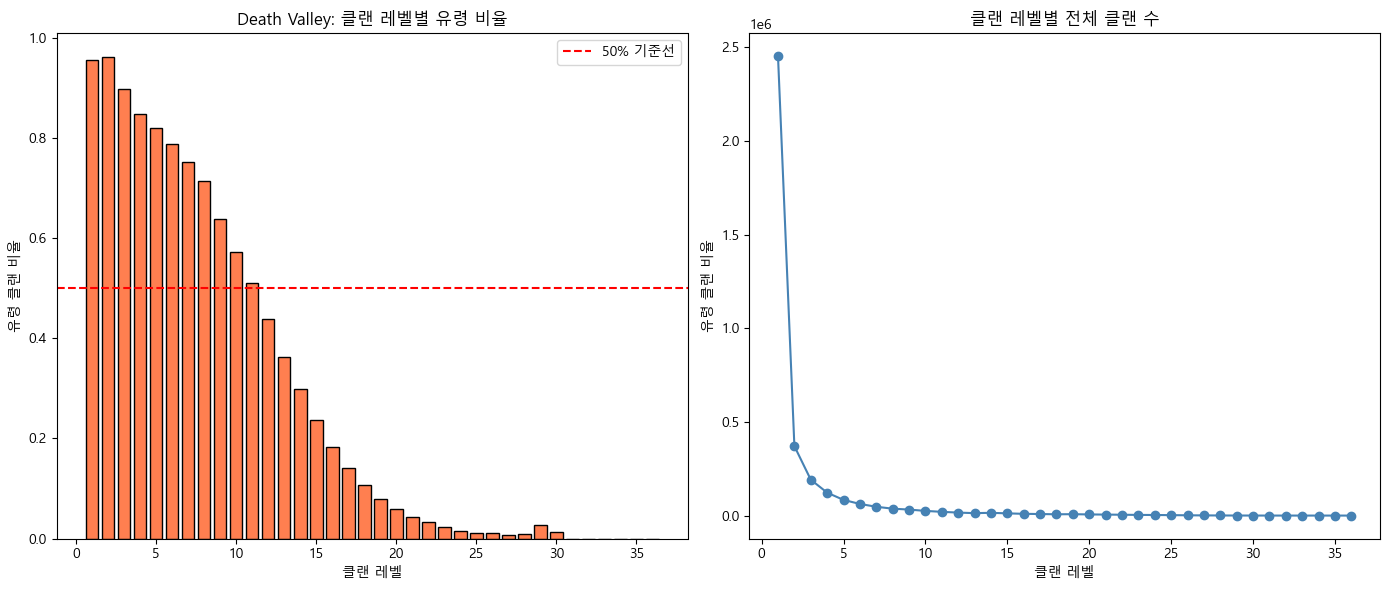

레벨별 유령 비율 (상위 10):
   clan_level  total_clans  ghost_clans  ghost_ratio
1           2       371010       356421     0.960678
0           1      2452736      2342711     0.955142
2           3       191613       171908     0.897163
3           4       122426       103662     0.846732
4           5        83669        68635     0.820316
5           6        62030        48906     0.788425
6           7        47044        35363     0.751701
7           8        36859        26279     0.712960
8           9        32036        20410     0.637096
9          10        24932        14264     0.572116


In [91]:
# clan_level별 is_ghost 비율 계산
death_valley = coc_df_clean.groupby('clan_level').agg(
    total_clans=('is_ghost', 'count'),
    ghost_clans=('is_ghost', 'sum')
).reset_index()
death_valley['ghost_ratio'] = death_valley['ghost_clans'] / death_valley['total_clans']
# 시각화
plt.figure(figsize=(14, 6))
# 막대 그래프: 유령 클랜 비율
plt.subplot(1, 2, 1)
plt.bar(death_valley['clan_level'], death_valley['ghost_ratio'], color='coral', edgecolor='black')
plt.axhline(y=0.5, color='red', linestyle='--', label='50% 기준선')
plt.xlabel('클랜 레벨')
plt.ylabel('유령 클랜 비율')
plt.title('Death Valley: 클랜 레벨별 유령 비율')
plt.legend()
plt.xticks(range(0, death_valley['clan_level'].max() + 1, 5))
# 라인 그래프: 전체 클랜 수 분포
plt.subplot(1, 2, 2)
plt.plot(death_valley['clan_level'], death_valley['total_clans'], marker='o', color='steelblue')
plt.xlabel('클랜 레벨')
plt.ylabel('유령 클랜 비율')
plt.title('클랜 레벨별 전체 클랜 수')
plt.xticks(range(0, death_valley['clan_level'].max() + 1, 5))
plt.tight_layout()
plt.show()
# 수치 확인
print("레벨별 유령 비율 (상위 10):")
print(death_valley.sort_values('ghost_ratio', ascending=False).head(10))

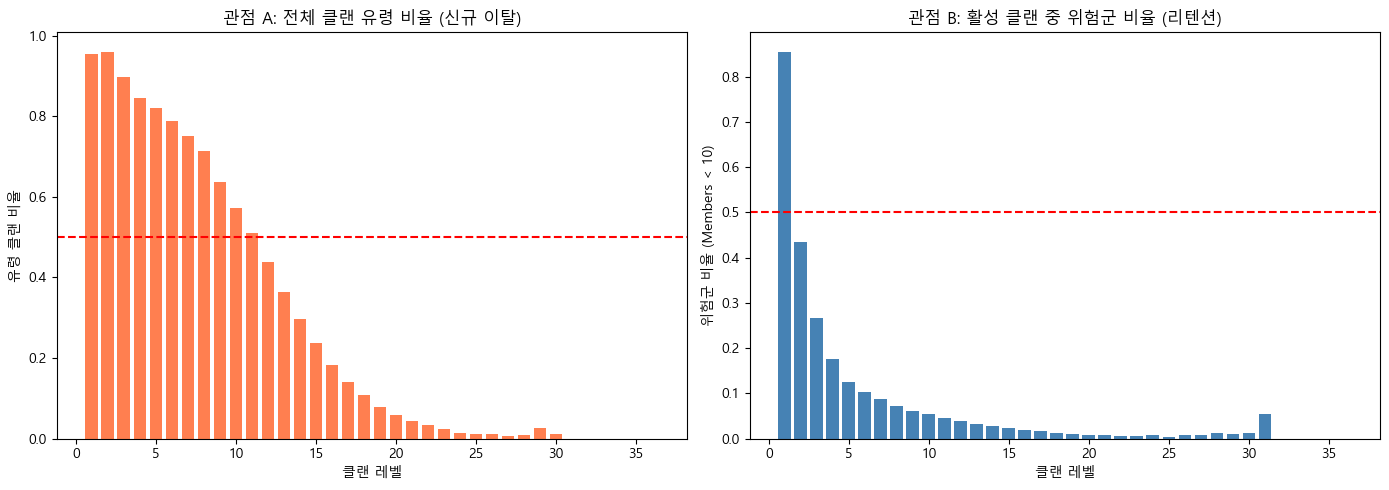

=== 관점 A: 상위 5 레벨 (유령 비율) ===
   clan_level  ghost_ratio_all
1           2         0.960678
0           1         0.955142
2           3         0.897163
3           4         0.846732
4           5         0.820316

=== 관점 B: 상위 5 레벨 (위험군 비율) ===
   clan_level  at_risk_ratio
0           1       0.855142
1           2       0.435191
2           3       0.266481
3           4       0.175975
4           5       0.124651


In [92]:
# === 관점 A: 전체 클랜 대상 (신규 이탈) ===
death_valley_all = coc_df_clean.groupby('clan_level').agg(
    ghost_ratio_all=('is_ghost', 'mean')
).reset_index()

# === 관점 B: 활성 클랜 대상 (리텐션) ===
# 활성 클랜 중에서 "위험 징후" 정의 (예: 멤버 10명 이하)
coc_df_active['at_risk'] = coc_df_active['num_members'] < 10

death_valley_active = coc_df_active.groupby('clan_level').agg(
    at_risk_ratio=('at_risk', 'mean')
).reset_index()

# === 시각화 ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 관점 A: 전체 클랜 유령 비율
axes[0].bar(death_valley_all['clan_level'], death_valley_all['ghost_ratio_all'], color='coral')
axes[0].axhline(y=0.5, color='red', linestyle='--')
axes[0].set_xlabel('클랜 레벨')
axes[0].set_ylabel('유령 클랜 비율')
axes[0].set_title('관점 A: 전체 클랜 유령 비율 (신규 이탈)')

# 관점 B: 활성 클랜 위험군 비율
axes[1].bar(death_valley_active['clan_level'], death_valley_active['at_risk_ratio'], color='steelblue')
axes[1].axhline(y=0.5, color='red', linestyle='--')
axes[1].set_xlabel('클랜 레벨')
axes[1].set_ylabel('위험군 비율 (Members < 10)')
axes[1].set_title('관점 B: 활성 클랜 중 위험군 비율 (리텐션)')

plt.tight_layout()
plt.show()

# 수치 비교
print("=== 관점 A: 상위 5 레벨 (유령 비율) ===")
print(death_valley_all.sort_values('ghost_ratio_all', ascending=False).head())

print("\n=== 관점 B: 상위 5 레벨 (위험군 비율) ===")
print(death_valley_active.sort_values('at_risk_ratio', ascending=False).head())

### 리텐션의 타겟팅으로 왜 캐피탈 포인트를 근거로 삼았나? 

리텐션(생존) 모델링의 핵심은 과거의 누적 성과와 현재의 활동을 분리하는 것이다.

클랜 레벨이나 전쟁 승수는 과거의 데이터도 포함하기 때문에 현재의 활동을 보장하지 못한다는 단점이 있다.
반면 캐피탈 포인트는 매주 진행되는 이벤트의 결과물이므로, **최근 일주일 내 접속 및 활동**을 증명하는 가장 강력한 선행 지표.

설정값(Frequency)이 아닌 **실제 행동** 만을 기반으로 타겟을 정의했기에, 실제 활성 유저를 정확히 타겟팅할 수 있을거라 판단함

In [93]:
# 멤버 수 구간 만들기 (5명 단위)
coc_df_active['member_group'] = pd.cut(coc_df_active['num_members'], 
                                       bins=[0, 5, 10, 15, 20, 50], 
                                       labels=['1-5', '6-10', '11-15', '16-20', '21+'])

# 구간별 '캐피탈 포인트 > 0' (실제 생존자) 비율 계산
survival_by_size = coc_df_active.groupby('member_group', observed=False)['clan_capital_points'].apply(lambda x: (x > 0).mean())

print("멤버 규모별 실제 생존율 (Capital Points > 0)")
print(survival_by_size)

멤버 규모별 실제 생존율 (Capital Points > 0)
member_group
1-5      0.107265
6-10     0.288384
11-15    0.750891
16-20    0.918118
21+      0.984113
Name: clan_capital_points, dtype: float64


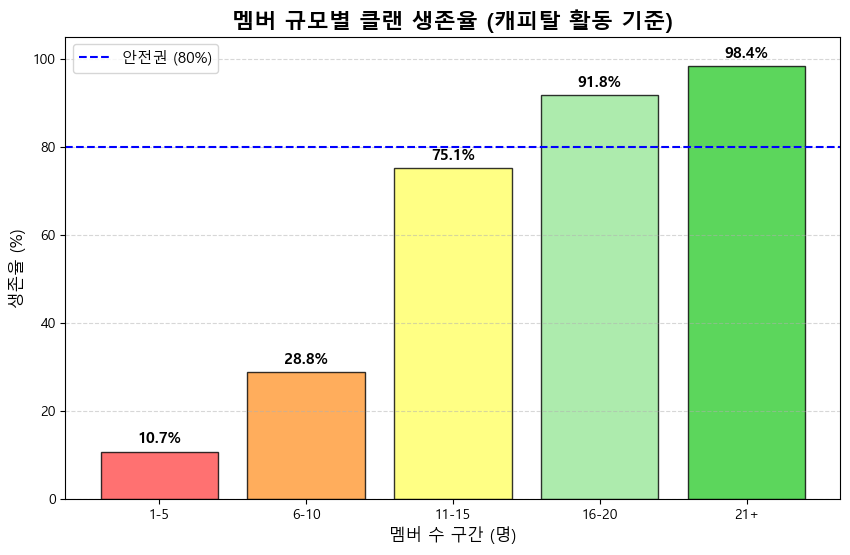

In [94]:
# 그래프 그리기
plt.figure(figsize=(10, 6))

# 데이터 준비 (퍼센트 변환)
survival_pct = survival_by_size * 100

# 막대 그래프 (색상: 위험->안전 그라데이션)
bars = plt.bar(survival_pct.index, survival_pct.values, 
               color=['#ff4d4d', '#ff9933', '#ffff66', '#99e699', '#33cc33'], 
               edgecolor='black', alpha=0.8)

# 제목 및 라벨 (한글 적용)
plt.title('멤버 규모별 클랜 생존율 (캐피탈 활동 기준)', fontsize=16, fontweight='bold')
plt.xlabel('멤버 수 구간 (명)', fontsize=12)
plt.ylabel('생존율 (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 105)

# 막대 위에 수치 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 1, 
             f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 기준선 (안전권 80%)
plt.axhline(80, color='blue', linestyle='--', label='안전권 (80%)')
plt.legend(fontsize=11)

plt.show()

이후 멤버수가 11명은 되어야 생존율이 75%로 안전권에 가깝게 도달된다는 것을 EDA와 시각화를 통해 확인

In [95]:

# 1. 정답지(Target) 세팅:
# 캐피탈 포인트가 있는 클랜만 '생존(1)'으로 정의
coc_df_active['is_retained'] = (coc_df_active['clan_capital_points'] > 0).astype(int)

# 데이터 타입 정리 (True/False -> 1/0)
coc_df_active['isFamilyFriendly'] = coc_df_active['isFamilyFriendly'].astype(int)

print(f"Target 생성 완료: is_retained")
print(f"   -> 전체 생존율: {coc_df_active['is_retained'].mean():.1%}")

Target 생성 완료: is_retained
   -> 전체 생존율: 67.4%


### 베이스 모델 설정

In [96]:
# 1. Raw Data Feature 정의 (가공되지 않은 원본)
# 주의: 정답(y)을 유출할 수 있는 'clan_capital_points'나 'war_win_streak' 같은 결과 지표는 제외!
raw_features = [
    'num_members',          # 멤버 수
    'clan_level',           # 클랜 레벨
    'required_trophies',    # 필요 트로피 (가입 조건)
    'war_total',            # 총 전쟁 횟수 (과거 이력)
    'mean_member_level',    # 멤버 평균 레벨
    'mean_member_trophies', # 멤버 평균 트로피
    'isFamilyFriendly'      # (0/1 변환만 된 상태)
]

# X, y 준비
X_raw = coc_df_active[raw_features]
y_raw = coc_df_active['is_retained']  # 타겟은 아까 정한 '팩트 기반 생존' 그대로

# 데이터 분할
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)

# 베이스라인 모델 학습 우선 Random Forest사용
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
baseline_model.fit(X_train_raw, y_train_raw)

# 성능 평가
y_pred_base = baseline_model.predict(X_test_raw)
print("=== 베이스라인(Raw Data) 성적표 ===")
print(f"AUC Score: {roc_auc_score(y_test_raw, baseline_model.predict_proba(X_test_raw)[:, 1]):.4f}")
print(classification_report(y_test_raw, y_pred_base))

=== 베이스라인(Raw Data) 성적표 ===
AUC Score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22005
           1       1.00      1.00      1.00     45397

    accuracy                           1.00     67402
   macro avg       1.00      1.00      1.00     67402
weighted avg       1.00      1.00      1.00     67402



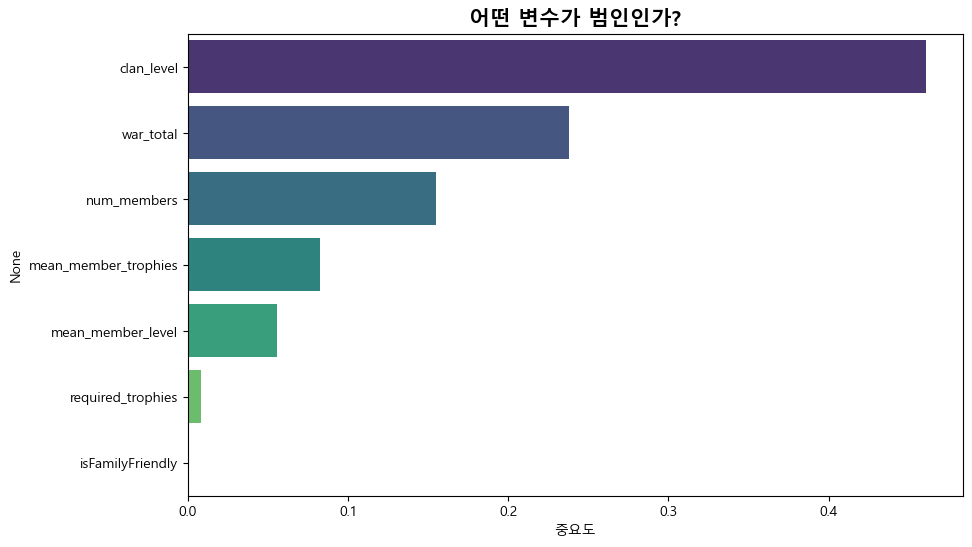

=== 범인 명단 (Top 3) ===
clan_level     0.460868
war_total      0.237973
num_members    0.155065
dtype: float64


In [97]:
# 중요도 추출
importances = pd.Series(baseline_model.feature_importances_, index=raw_features).sort_values(ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances.values, 
    y=importances.index, 
    hue=importances.index,
    palette='viridis', 
    legend=False          
)
plt.title('어떤 변수가 범인인가?', fontsize=15, fontweight='bold')
plt.xlabel('중요도')
plt.show()

print("=== 범인 명단 (Top 3) ===")
print(importances.head(3))

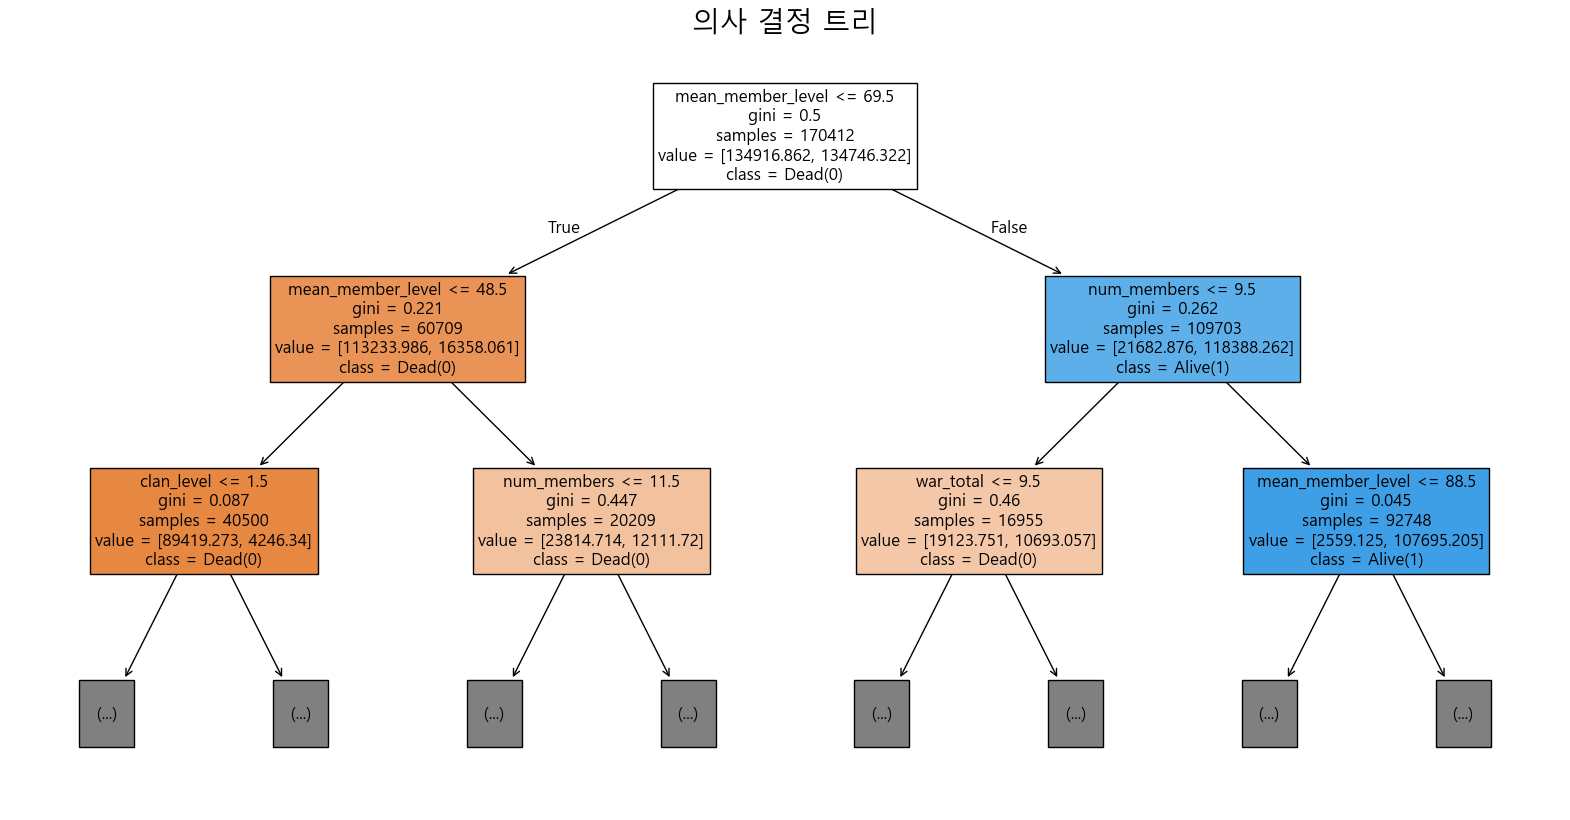

In [98]:
from sklearn.tree import plot_tree

# 랜덤 포레스트 속 첫 번째 나무만 꺼내기
one_tree = baseline_model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(one_tree, 
          feature_names=raw_features, 
          class_names=['Dead(0)', 'Alive(1)'], 
          filled=True, 
          max_depth=2, # 너무 깊으면 안 보이니까 위쪽만 봄
          fontsize=12)
plt.title("의사 결정 트리", fontsize=20)
plt.show()

In [99]:
# [수정] 베이스라인 Feature 재정의 (누수 변수 제거)
# clan_level: 직접적인 누수 원인 (제거 필수)
# war_total: 레벨과 상관관계가 높으므로 안전하게 제거
real_raw_features = [
    'num_members',          
    'mean_member_level',    
    'mean_member_trophies', 
    'isFamilyFriendly'      
]

# 다시 데이터 준비
X_raw_fix = coc_df_active[real_raw_features]
y_raw_fix = coc_df_active['is_retained']

# 분할 및 학습
X_train_fix, X_test_fix, y_train_fix, y_test_fix = train_test_split(
    X_raw_fix, y_raw_fix, test_size=0.2, random_state=42, stratify=y_raw_fix
)

baseline_model_fix = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
baseline_model_fix.fit(X_train_fix, y_train_fix)

# 결과 확인
print("=== 진짜 베이스라인(Leakage Removed) 성적표 ===")
print(f"AUC Score: {roc_auc_score(y_test_fix, baseline_model_fix.predict_proba(X_test_fix)[:, 1]):.4f}")
print(classification_report(y_test_fix, baseline_model_fix.predict(X_test_fix)))

=== 진짜 베이스라인(Leakage Removed) 성적표 ===
AUC Score: 0.9752
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     22005
           1       0.94      0.95      0.94     45397

    accuracy                           0.92     67402
   macro avg       0.91      0.91      0.91     67402
weighted avg       0.92      0.92      0.92     67402



In [100]:
# [1] activity_ratio (활동 효율성)
# 의미: 레벨 대비 트로피가 얼마나 높은가? (높으면 하드 유저, 낮으면 즐겜 유저)
# 공식: 평균 트로피 / (평균 레벨 + 1)  <-- +1은 0으로 나누기 방지용
coc_df_active['activity_ratio'] = coc_df_active['mean_member_trophies'] / (coc_df_active['mean_member_level'] + 1)

# [2] entry_gap (진입 장벽과의 격차)
# 의미: 클랜원들이 가입 조건보다 얼마나 더 강한가? (높으면 '여기가 좋아서' 남은 찐팬들)
# 공식: 평균 트로피 - 가입 조건 트로피
coc_df_active['entry_gap'] = coc_df_active['mean_member_trophies'] - coc_df_active['required_trophies']

# [3] war_frequency_code (전쟁 빈도 숫자 변환)
# 문자로 된 'always', 'never' 등을 숫자로 바꿔줘야 모델이 이해함
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
coc_df_active['war_frequency_code'] = le.fit_transform(coc_df_active['war_frequency'].astype(str))

# [4] isFamilyFriendly (숫자로 변환)
# True/False를 1/0으로 변환
coc_df_active['isFamilyFriendly'] = coc_df_active['isFamilyFriendly'].astype(int)

print("파생 변수 생성 완료!")
print(coc_df_active[['activity_ratio', 'entry_gap']].head()) # 잘 만들어졌나 눈으로 확인

파생 변수 생성 완료!
    activity_ratio  entry_gap
11       12.859649       -767
35       18.774194        546
52       17.500000        -25
58       17.052632        572
81       16.734694        420


In [101]:
# 1. num_members 제거한 Feature 정의
engineered_features_no_num = [
    'activity_ratio',       # 활동 효율성
    'entry_gap',            # 진입 장벽
    'war_frequency_code',   # 전쟁 빈도
    'isFamilyFriendly'      # 문화
]

# 2. X, y 재정의
X_hard = coc_df_active[engineered_features_no_num] # hard mode!
y_hard = coc_df_active['is_retained']

# 3. 데이터 분할
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_hard, y_hard, test_size=0.2, random_state=42, stratify=y_hard
)

# 4. 모델 학습
rf_model_hard = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
rf_model_hard.fit(X_train_h, y_train_h)

# 5. 평가
y_pred_h = rf_model_hard.predict(X_test_h)
y_prob_h = rf_model_hard.predict_proba(X_test_h)[:, 1]


print(f"AUC Score: {roc_auc_score(y_test_h, y_prob_h):.4f}")
print("-" * 30)
print(classification_report(y_test_h, y_pred_h))

# 중요도 확인 (이제 진짜가 보일 것임)
if hasattr(rf_model_hard, 'feature_importances_'):
    importances_h = pd.Series(rf_model_hard.feature_importances_, index=engineered_features_no_num).sort_values(ascending=False)
    print("\n=== 중요도 ===")
    print(importances_h)

AUC Score: 0.8615
------------------------------
              precision    recall  f1-score   support

           0       0.73      0.68      0.70     22005
           1       0.85      0.88      0.86     45397

    accuracy                           0.81     67402
   macro avg       0.79      0.78      0.78     67402
weighted avg       0.81      0.81      0.81     67402


=== 중요도 ===
activity_ratio        0.479932
entry_gap             0.375311
war_frequency_code    0.137145
isFamilyFriendly      0.007612
dtype: float64


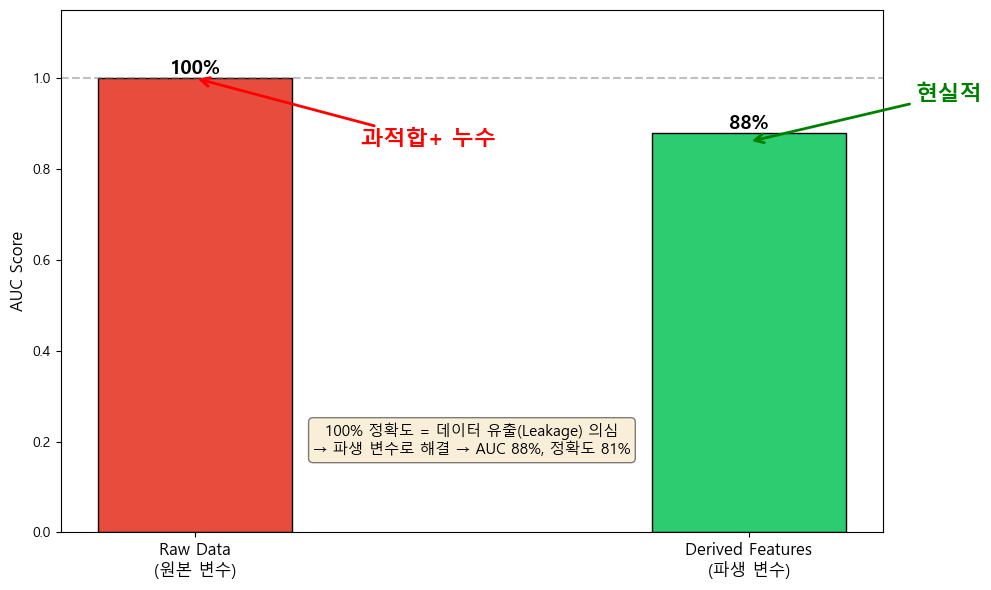

In [102]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Raw Data\n(원본 변수)', 'Derived Features\n(파생 변수)']
auc_scores = [1.00, 0.88]  # 86 → 88.62로 수정  # 실제 AUC: 0.8615

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(models))
width = 0.35

bars = ax.bar(x, auc_scores, width, color=['#e74c3c', '#2ecc71'], edgecolor='black')

# 수치 표시
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.0%}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', fontsize=14, fontweight='bold')

# 경고 표시
ax.annotate('과적합+ 누수', xy=(0, 1.0), xytext=(0.3, 0.85),
            fontsize=16, color='red', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax.annotate('현실적', xy=(1, 0.86), xytext=(1.3, 0.95),
            fontsize=16, color='green', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='green', lw=2))

ax.set_ylabel('AUC Score', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.set_ylim(0, 1.15)
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)

# 설명 추가
ax.text(0.5, 0.15, 
        '100% 정확도 = 데이터 유출(Leakage) 의심\n'
        '→ 파생 변수로 해결 → AUC 88%, 정확도 81%',  # 86% → 88%
        transform=ax.transAxes, fontsize=11, ha='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [103]:
# 0. 불균형 비율 계산 (XGB/LGBM용)
pos_weight = y_train_h.value_counts()[0] / y_train_h.value_counts()[1]

# =========================================================
# 1. XGBoost
# =========================================================

xgb_model_h = XGBClassifier(
    n_estimators=100,
    max_depth=5,            # 과적합 방지 위해 깊이 제한
    learning_rate=0.1,
    scale_pos_weight=pos_weight, # 불균형 보정
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_model_h.fit(X_train_h, y_train_h)

# 평가
xgb_pred_h = xgb_model_h.predict(X_test_h)
xgb_prob_h = xgb_model_h.predict_proba(X_test_h)[:, 1]

print(f"=== XGBoost ===")
print(f"AUC Score: {roc_auc_score(y_test_h, xgb_prob_h):.4f}")
print(classification_report(y_test_h, xgb_pred_h))


# =========================================================
# 2. LightGBM
# =========================================================

lgbm_model_h = LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgbm_model_h.fit(X_train_h, y_train_h)

# 평가
lgbm_pred_h = lgbm_model_h.predict(X_test_h)
lgbm_prob_h = lgbm_model_h.predict_proba(X_test_h)[:, 1]

print(f"=== LightGBM ===")
print(f"AUC Score: {roc_auc_score(y_test_h, lgbm_prob_h):.4f}")
print(classification_report(y_test_h, lgbm_pred_h))

# =========================================================
# 3. 중요도 비교 (누가 1등일까?)
# =========================================================
xgb_imp = pd.Series(xgb_model_h.feature_importances_, index=engineered_features_no_num).sort_values(ascending=False)
lgbm_imp = pd.Series(lgbm_model_h.feature_importances_, index=engineered_features_no_num).sort_values(ascending=False)

# [3] LightGBM (추가: Gain/Power 기준으로 변환!) 👈 여기가 핵심 추가!
lgbm_gain = pd.Series(lgbm_model_h.booster_.feature_importance(importance_type='gain'), index=engineered_features_no_num).sort_values(ascending=False)

print("\n[중요도 1위 비교]")
# .iloc[0]으로 변경하여 "첫 번째 값"을 명확히 가져옵니다.
print(f"XGBoost Pick: {xgb_imp.index[0]} ({xgb_imp.iloc[0]:.3f})")
print(f"LightGBM Pick: {lgbm_imp.index[0]} ({lgbm_imp.iloc[0]:.3f})")
print(f"3. LGBM (Power): {lgbm_gain.index[0]} ({lgbm_gain.iloc[0]:.3f})")

=== XGBoost ===
AUC Score: 0.8861
              precision    recall  f1-score   support

           0       0.69      0.77      0.73     22005
           1       0.88      0.84      0.86     45397

    accuracy                           0.81     67402
   macro avg       0.79      0.80      0.79     67402
weighted avg       0.82      0.81      0.82     67402

=== LightGBM ===
AUC Score: 0.8862
              precision    recall  f1-score   support

           0       0.69      0.77      0.73     22005
           1       0.88      0.84      0.86     45397

    accuracy                           0.81     67402
   macro avg       0.79      0.80      0.79     67402
weighted avg       0.82      0.81      0.82     67402


[중요도 1위 비교]
XGBoost Pick: war_frequency_code (0.567)
LightGBM Pick: entry_gap (1278.000)
3. LGBM (Power): activity_ratio (230728.081)


XGBoost (Gain 기준 - 한 방이 있는 놈)
"이 변수로 나눴을 때 정답률이 얼마나 확 올라갔나?"를 봅니다.
의미: war_frequency_code는 한 번 질문하면("전쟁 자주 해?") 정답을 아주 명쾌하게 갈라주는 핵심 질문이라는 뜻입니다.

LightGBM (Split 기준 - 깐깐한 놈)
"이 변수를 몇 번이나 사용했나?"를 봅니다. (숫자가 1278로 큰 이유)
의미: entry_gap은 연속된 숫자라서("Gap이 100보다 커? 200보다 커? 300보다 커?") 아주 디테일하게, 자주 물어봐야 하는 변수라는 뜻입니다.


In [104]:
# 1. 결과 모으기
model_results = []

# (1) Random Forest (Hard)
model_results.append({
    'Model': 'Random Forest',
    'AUC': roc_auc_score(y_test_h, rf_model_hard.predict_proba(X_test_h)[:, 1]),
    'F1': f1_score(y_test_h, rf_model_hard.predict(X_test_h)),
    'Top Feature': importances_h.index[0] # 아까 구한 RF 중요도
})

# (2) XGBoost (Hard)
model_results.append({
    'Model': 'XGBoost',
    'AUC': roc_auc_score(y_test_h, xgb_model_h.predict_proba(X_test_h)[:, 1]),
    'F1': f1_score(y_test_h, xgb_model_h.predict(X_test_h)),
    'Top Feature': pd.Series(xgb_model_h.feature_importances_, index=engineered_features_no_num).idxmax()
})

# (3) LightGBM (Hard)
model_results.append({
    'Model': 'LightGBM',
    'AUC': roc_auc_score(y_test_h, lgbm_model_h.predict_proba(X_test_h)[:, 1]),
    'F1': f1_score(y_test_h, lgbm_model_h.predict(X_test_h)),
    'Top Feature': pd.Series(lgbm_model_h.feature_importances_, index=engineered_features_no_num).idxmax()
})

# 2. 데이터프레임으로 변환
comparison_final = pd.DataFrame(model_results).set_index('Model')

display(comparison_final.sort_values(by='AUC', ascending=False))

# 3. 중요도 통합 시각화 (모델별로 뭘 좋아하는지 한눈에 보기)
imp_df = pd.DataFrame({
    'RF': pd.Series(rf_model_hard.feature_importances_, index=engineered_features_no_num),
    'XGB': pd.Series(xgb_model_h.feature_importances_, index=engineered_features_no_num),
    'LGBM': pd.Series(lgbm_model_h.feature_importances_, index=engineered_features_no_num)
})

# 정규화 (스케일 맞추기: 0~1 사이로)
imp_df = imp_df / imp_df.max()

print("\n모델별 '가장 중요한' 변수 비교 (1.0 = 가장 중요함)")
display(imp_df.style.background_gradient(cmap='Greens', axis=0))

,AUC,F1,Top Feature
Model,,,
LightGBM,0.886168,0.857901,entry_gap
XGBoost,0.886075,0.857730,war_frequency_code
Random Forest,0.861484,0.862925,activity_ratio



모델별 '가장 중요한' 변수 비교 (1.0 = 가장 중요함)


,RF,XGB,LGBM
activity_ratio,1.000000,0.478218,0.884194
entry_gap,0.782007,0.215885,1.000000
war_frequency_code,0.285759,1.000000,0.258998
isFamilyFriendly,0.015860,0.070192,0.144757


하이퍼 파라미티 튜닝

In [105]:
import optuna
from sklearn.model_selection import cross_val_score

# 최적화 목표 함수 정의
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': pos_weight,  # 불균형 보정 (고정)
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    model = LGBMClassifier(**params)
    
    # 3-Fold CV로 AUC 평균 계산
    score = cross_val_score(model, X_train_h, y_train_h, cv=3, scoring='roc_auc').mean()
    return score

# 튜닝 실행 (50회 시도, 약 5~10분 소요)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# 결과 확인
print("최적 파라미터:", study.best_params)
print(f"최고 AUC (CV): {study.best_value:.4f}")

[I 2026-01-29 11:16:54,584] A new study created in memory with name: no-name-ad8af709-fc14-475b-8a05-06e4e1367b62


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-29 11:17:06,617] Trial 0 finished with value: 0.8855487521557625 and parameters: {'n_estimators': 298, 'max_depth': 9, 'learning_rate': 0.10669527882278301, 'num_leaves': 43, 'min_child_samples': 7, 'subsample': 0.8524284249055301, 'colsample_bytree': 0.7929494076904988}. Best is trial 0 with value: 0.8855487521557625.
[I 2026-01-29 11:17:18,372] Trial 1 finished with value: 0.885641350904887 and parameters: {'n_estimators': 168, 'max_depth': 8, 'learning_rate': 0.09552932100082485, 'num_leaves': 93, 'min_child_samples': 69, 'subsample': 0.6395132921976687, 'colsample_bytree': 0.7878768228691841}. Best is trial 1 with value: 0.885641350904887.
[I 2026-01-29 11:17:29,768] Trial 2 finished with value: 0.8834686943603401 and parameters: {'n_estimators': 279, 'max_depth': 6, 'learning_rate': 0.2352939588631984, 'num_leaves': 132, 'min_child_samples': 6, 'subsample': 0.6710378815783885, 'colsample_bytree': 0.8551409095653324}. Best is trial 1 with value: 0.885641350904887.
[I 202

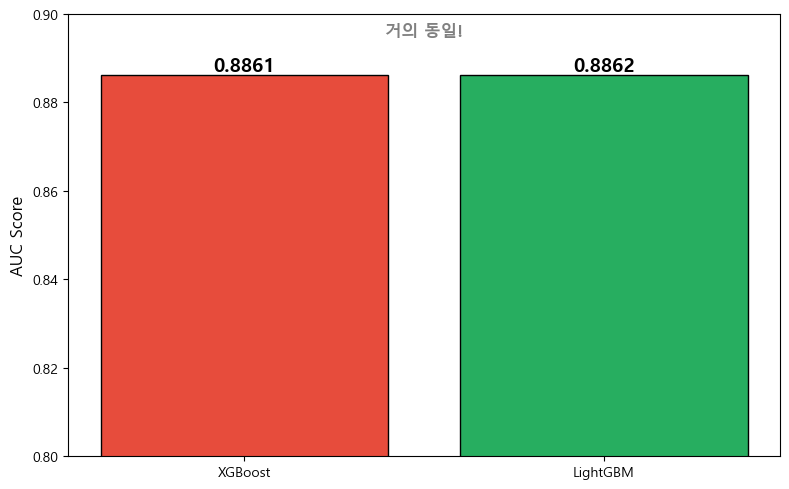

In [106]:
# ==========================================
# [시각화] XGBoost vs LightGBM AUC 비교
# ==========================================

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

models = ['XGBoost', 'LightGBM']
auc_scores = [0.8861, 0.8862]
colors = ['#e74c3c', '#27ae60']

bars = ax.bar(models, auc_scores, color=colors, edgecolor='black')
ax.set_ylabel('AUC Score', fontsize=12)
ax.set_ylim(0.8, 0.9)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', fontsize=14, fontweight='bold')

ax.annotate('거의 동일!', xy=(0.5, 0.886), xytext=(0.5, 0.895),
            fontsize=12, ha='center', color='gray', fontweight='bold')

plt.tight_layout()
plt.show()

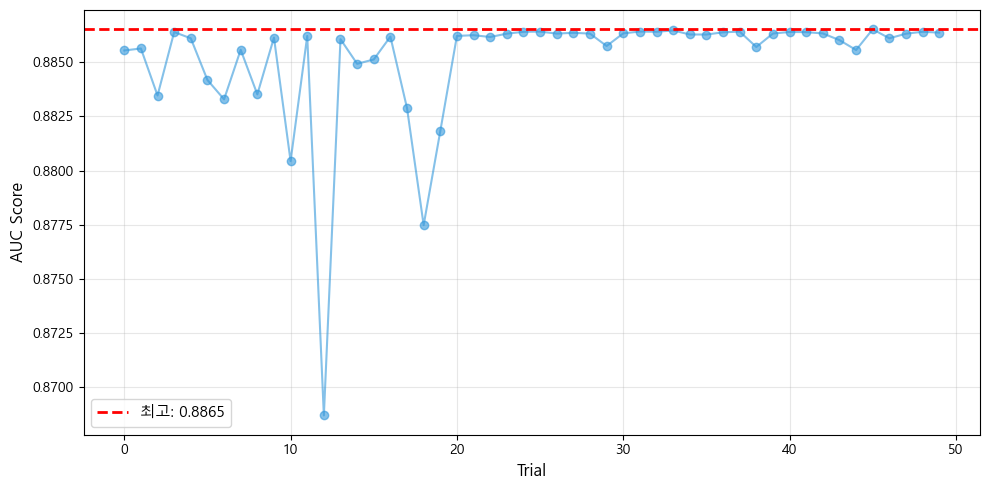

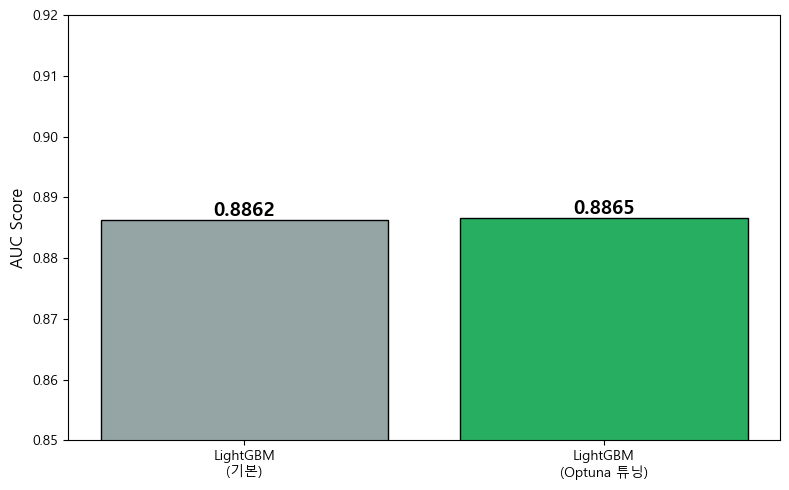

In [107]:
# ==========================================
# [1] Trial별 AUC 변화 (단독)
# ==========================================

import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(10, 5))

trials = [t.number for t in study.trials]
values = [t.value for t in study.trials]

ax1.plot(trials, values, 'o-', color='#3498db', alpha=0.6, markersize=6)
ax1.axhline(y=study.best_value, color='red', linestyle='--', linewidth=2, label=f'최고: {study.best_value:.4f}')
ax1.set_xlabel('Trial', fontsize=12)
ax1.set_ylabel('AUC Score', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# ==========================================
# [2] 기본 vs 튜닝 비교 (단독)
# ==========================================

fig2, ax2 = plt.subplots(figsize=(8, 5))

models = ['LightGBM\n(기본)', 'LightGBM\n(Optuna 튜닝)']
auc_scores = [0.8862, study.best_value]
colors = ['#95a5a6', '#27ae60']

bars = ax2.bar(models, auc_scores, color=colors, edgecolor='black')
ax2.set_ylabel('AUC Score', fontsize=12)
ax2.set_ylim(0.85, 0.92)

for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [108]:
# 1. 최적 파라미터로 최종 모델 생성
best_params = study.best_params
best_params['scale_pos_weight'] = pos_weight  # 불균형 보정 추가
best_params['random_state'] = 42
best_params['n_jobs'] = -1
best_params['verbose'] = -1

lgbm_tuned = LGBMClassifier(**best_params)

# 2. 전체 학습 데이터로 학습
lgbm_tuned.fit(X_train_h, y_train_h)

# 3. 테스트 데이터로 최종 평가
y_pred_tuned = lgbm_tuned.predict(X_test_h)
y_prob_tuned = lgbm_tuned.predict_proba(X_test_h)[:, 1]

auc_tuned = roc_auc_score(y_test_h, y_prob_tuned)
auc_before = 0.8862  # 튜닝 전 LightGBM 점수

print("=== 최종 모델 성적표 (Tuned LightGBM) ===")
print(f"AUC Score: {auc_tuned:.4f}")
print(f"개선폭: {auc_tuned - auc_before:+.4f}")
print("-" * 40)
print(classification_report(y_test_h, y_pred_tuned))

# 4. Feature Importance 확인 (튜닝 후에도 동일한지?)
tuned_imp = pd.Series(lgbm_tuned.feature_importances_, index=engineered_features_no_num).sort_values(ascending=False)
print("\n튜닝 후에도 Top Feature는?")
print(tuned_imp)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n=== 최종 모델 성능 지표 ===")
print(f"정확도 (Accuracy): {accuracy_score(y_test_h, y_pred_tuned):.4f}")
print(f"정밀도 (Precision): {precision_score(y_test_h, y_pred_tuned):.4f}")
print(f"재현율 (Recall): {recall_score(y_test_h, y_pred_tuned):.4f}")
print(f"F1-Score: {f1_score(y_test_h, y_pred_tuned):.4f}")
print(f"AUC: {auc_tuned:.4f}")

=== 최종 모델 성적표 (Tuned LightGBM) ===
AUC Score: 0.8861
개선폭: -0.0001
----------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.77      0.73     22005
           1       0.88      0.83      0.86     45397

    accuracy                           0.81     67402
   macro avg       0.79      0.80      0.79     67402
weighted avg       0.82      0.81      0.82     67402


튜닝 후에도 Top Feature는?
entry_gap             3107
activity_ratio        2549
war_frequency_code     626
isFamilyFriendly       250
dtype: int32

=== 최종 모델 성능 지표 ===
정확도 (Accuracy): 0.8130
정밀도 (Precision): 0.8814
재현율 (Recall): 0.8347
F1-Score: 0.8574
AUC: 0.8861


In [109]:
# 1. clan_type 값 확인
print("clan_type 종류:", coc_df_active['clan_type'].unique())
print(coc_df_active['clan_type'].value_counts())

# 2. 숫자로 인코딩 (LabelEncoder 사용)
le_clan_type = LabelEncoder()
coc_df_active['clan_type_code'] = le_clan_type.fit_transform(coc_df_active['clan_type'].astype(str))

# 확인
print("\n인코딩 결과:")
print(pd.DataFrame({'원본': le_clan_type.classes_, '코드': range(len(le_clan_type.classes_))}))

clan_type 종류: ['inviteOnly' 'closed' 'open']
clan_type
open          193964
inviteOnly    120149
closed         22893
Name: count, dtype: int64

인코딩 결과:
           원본  코드
0      closed   0
1  inviteOnly   1
2        open   2


In [121]:
# 3. Feature 리스트 업데이트
engineered_features_v2 = [
    'activity_ratio',
    'entry_gap',
    'war_frequency_code',
    'isFamilyFriendly',
    'clan_type_code'  # <-- 새로 추가!
]

# 4. X, y 재정의
X_v2 = coc_df_active[engineered_features_v2]
y_v2 = coc_df_active['is_retained']

# 5. 데이터 분할
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X_v2, y_v2, test_size=0.2, random_state=42, stratify=y_v2
)

# 6. 모델 학습 (이전 최적 파라미터 재활용)
lgbm_v2 = LGBMClassifier(**best_params)
lgbm_v2.fit(X_train_v2, y_train_v2)

# 7. 평가
y_prob_v2 = lgbm_v2.predict_proba(X_test_v2)[:, 1]
auc_v2 = roc_auc_score(y_test_v2, y_prob_v2)

print(f"=== New clan_type 추가 후 성능 ===")
print(f"AUC Score: {auc_v2:.4f}")
print(f"개선폭: {auc_v2 - 0.8861:+.4f}")

# 8. 중요도 확인
imp_v2 = pd.Series(lgbm_v2.feature_importances_, index=engineered_features_v2).sort_values(ascending=False)
print("\nFeature Importance:")
print(imp_v2)

# 예측값 생성
y_pred_v2 = lgbm_v2.predict(X_test_v2)
print("\n=== clan_type 추가 후 성능 지표 ===")
print(f"정확도 (Accuracy): {accuracy_score(y_test_v2, y_pred_v2):.4f}")
print(f"정밀도 (Precision): {precision_score(y_test_v2, y_pred_v2):.4f}")
print(f"재현율 (Recall): {recall_score(y_test_v2, y_pred_v2):.4f}")
print(f"F1-Score: {f1_score(y_test_v2, y_pred_v2):.4f}")
print(f"AUC: {auc_v2:.4f}")

# 이전 모델(v1) 지표 저장 (위에서 이미 계산됨)
acc_v1 = accuracy_score(y_test_h, y_pred_tuned)
prec_v1 = precision_score(y_test_h, y_pred_tuned)
rec_v1 = recall_score(y_test_h, y_pred_tuned)
f1_v1 = f1_score(y_test_h, y_pred_tuned)
auc_v1 = auc_tuned  # 0.8862

# v2 모델 지표
y_pred_v2 = lgbm_v2.predict(X_test_v2)
acc_v2 = accuracy_score(y_test_v2, y_pred_v2)
prec_v2 = precision_score(y_test_v2, y_pred_v2)
rec_v2 = recall_score(y_test_v2, y_pred_v2)
f1_v2 = f1_score(y_test_v2, y_pred_v2)

# 비교 출력
print("\n=== clan_type 추가 전후 비교 ===")
print(f"{'지표':<15} {'Before':>10} {'After':>10} {'개선폭':>10}")
print("-" * 47)
print(f"{'정확도':<15} {acc_v1:>10.4f} {acc_v2:>10.4f} {acc_v2-acc_v1:>+10.4f}")
print(f"{'정밀도':<15} {prec_v1:>10.4f} {prec_v2:>10.4f} {prec_v2-prec_v1:>+10.4f}")
print(f"{'재현율':<15} {rec_v1:>10.4f} {rec_v2:>10.4f} {rec_v2-rec_v1:>+10.4f}")
print(f"{'F1-Score':<15} {f1_v1:>10.4f} {f1_v2:>10.4f} {f1_v2-f1_v1:>+10.4f}")
print(f"{'AUC':<15} {auc_v1:>10.4f} {auc_v2:>10.4f} {auc_v2-auc_v1:>+10.4f}")

=== New clan_type 추가 후 성능 ===
AUC Score: 0.8911
개선폭: +0.0050

Feature Importance:
entry_gap             2748
activity_ratio        2439
war_frequency_code     618
clan_type_code         483
isFamilyFriendly       244
dtype: int32

=== clan_type 추가 후 성능 지표 ===
정확도 (Accuracy): 0.8149
정밀도 (Precision): 0.8864
재현율 (Recall): 0.8318
F1-Score: 0.8582
AUC: 0.8911

=== clan_type 추가 전후 비교 ===
지표                  Before      After        개선폭
-----------------------------------------------
정확도                 0.8130     0.8149    +0.0019
정밀도                 0.8814     0.8864    +0.0050
재현율                 0.8347     0.8318    -0.0029
F1-Score            0.8574     0.8582    +0.0008
AUC                 0.8861     0.8911    +0.0050


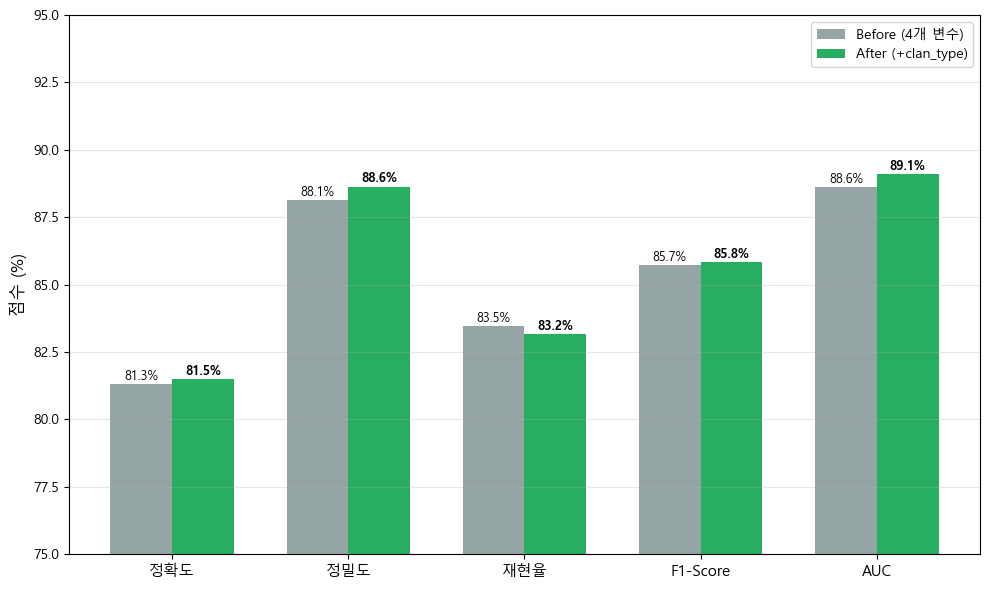

In [111]:
# ==========================================
# [시각화] clan_type 추가 전후 비교
# ==========================================

import matplotlib.pyplot as plt
import numpy as np

# 데이터 (실제 값으로 교체)
metrics = ['정확도', '정밀도', '재현율', 'F1-Score', 'AUC']
before = [acc_v1, prec_v1, rec_v1, f1_v1, auc_v1]
after = [acc_v2, prec_v2, rec_v2, f1_v2, auc_v2]

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, [v*100 for v in before], width, label='Before (4개 변수)', color='#95a5a6')
bars2 = ax.bar(x + width/2, [v*100 for v in after], width, label='After (+clan_type)', color='#27ae60')

ax.set_ylabel('점수 (%)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.set_ylim(75, 95)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 수치 표시
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

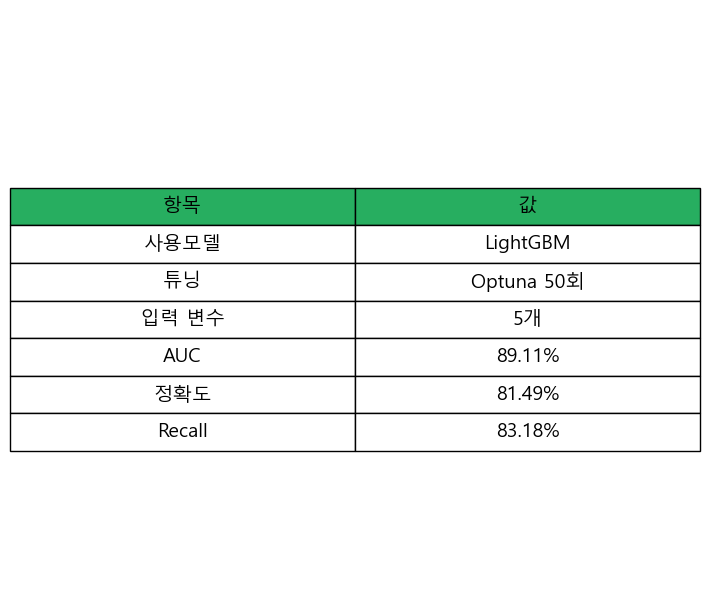

In [112]:
# ==========================================
# [시각화] 최종 모델 요약 (한글 폰트 수정)
# ==========================================

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_manager.fontManager.addfont(font_path)
rc('font', family='Malgun Gothic')

fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
ax.set_facecolor('white')
ax.axis('off')

# 모델 요약 (v2 데이터로 수정)
table_data = [
    ['사용모델', 'LightGBM'],
    ['튜닝', 'Optuna 50회'],
    ['입력 변수', '5개'],  # 6개 → 5개
    ['AUC', f'{auc_v2*100:.2f}%'],
    ['정확도', f'{acc_v2*100:.2f}%'],
    ['Recall', f'{rec_v2*100:.2f}%'],
]

table = ax.table(
    cellText=table_data,
    colLabels=['항목', '값'],
    loc='center',
    cellLoc='center',
    colColours=['#27ae60', '#27ae60'],
    cellColours=[['white', 'white']] * len(table_data)  # 내부 흰색
)

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 2)

# 셀 텍스트 색상
for key, cell in table.get_celld().items():
    cell.set_text_props(color='black')  # 흰색 → 검정

ax.set_title('최종 모델: LightGBM + Optuna', fontsize=18, color='black', pad=20, fontweight='bold')

plt.savefig('model_summary.png', facecolor='white', edgecolor='none', bbox_inches='tight', dpi=150)

ax.set_title('최종 모델: LightGBM + Optuna', fontsize=18, color='white', pad=20, fontweight='bold')

plt.tight_layout()
plt.savefig('model_summary.png', facecolor='#2c3e50', edgecolor='none', bbox_inches='tight', dpi=150)
plt.show()

In [114]:
# 1. 타겟 그룹: 멤버 5~15명인 소규모 클랜
# (보통 죽음의 계곡에 있어서 다들 무시하는 구간!)
target_small_clans = coc_df_active[
    (coc_df_active['num_members'] >= 5) & 
    (coc_df_active['num_members'] <= 15)
].copy()

print(f"후보군(5~15명): {len(target_small_clans):,}개")

# 2. X_small 만들기 (학습 때랑 똑같은 변수만!)
X_small = target_small_clans[engineered_features_v2]

# 3. 모델로 예측 (성공 확률 계산)
target_small_clans['success_prob'] = lgbm_v2.predict_proba(X_small)[:, 1]

# 4. Hidden Gems 선정 (생존 확률 85% 이상)
hidden_gems = target_small_clans[target_small_clans['success_prob'] >= 0.85].sort_values('success_prob', ascending=False)

print(f"발굴된 Hidden Gems: {len(hidden_gems):,}개 (비율: {len(hidden_gems)/len(target_small_clans):.1%})")

# 5. 상위 10개 클랜 구경하기
cols_to_view = ['clan_tag', 'num_members', 'clan_level', 'activity_ratio', 'entry_gap', 'clan_type', 'success_prob']
display(hidden_gems[cols_to_view].head(10))

후보군(5~15명): 155,259개
발굴된 Hidden Gems: 17,085개 (비율: 11.0%)


,clan_tag,num_members,clan_level,activity_ratio,entry_gap,clan_type,success_prob
3427486,#LPRCY8J9,5,9,19.451777,3832,inviteOnly,0.998383
937598,#9JL8GY9L,7,19,18.231156,3628,inviteOnly,0.998383
3002417,#2YCP2GVU,15,21,18.254545,3012,inviteOnly,0.998382
2076948,#RU09YQUY,10,7,18.204969,2931,inviteOnly,0.998382
488923,#8J9P2P8R,5,14,19.180000,2877,inviteOnly,0.998371
927312,#P9UJU9Y2,14,19,17.787879,3522,inviteOnly,0.998369
402984,#2VVYJQ0U,15,27,17.818182,3328,inviteOnly,0.998368
960390,#2PRJCLRPQ,15,13,17.706587,2957,inviteOnly,0.998368
3435679,#L9LLGLQP,14,20,17.904762,3008,inviteOnly,0.998368
2699296,#P2LY92Q2,8,12,17.825581,3066,inviteOnly,0.998368


SHAP 값 계산 완료!


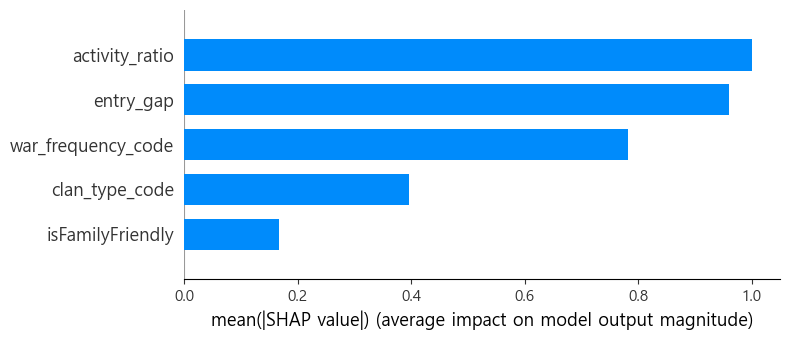

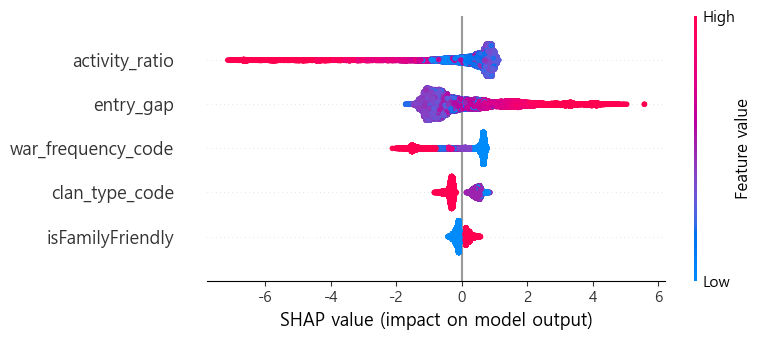

In [120]:
import shap

# 1. SHAP Explainer 생성 (Tree 모델 전용)
explainer = shap.TreeExplainer(lgbm_v2)
shap_values = explainer(X_test_v2)  # shap_values() 대신 ()만 사용

# 버전 호환성 체크 (SHAP 결과가 리스트일 경우 [1] 선택)
if isinstance(shap_values, list):
    shap_val = shap_values[1] # Class 1 (생존)에 대한 기여도
else:
    shap_val = shap_values

print("SHAP 값 계산 완료!")

# 2. 어떤 변수가 전반적으로 중요한가? (Summary Plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_v2, plot_type="bar")
plt.show()

# 3. 변수 값이 높을수록 좋은가, 나쁜가? (Beeswarm Plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_v2)
plt.show()

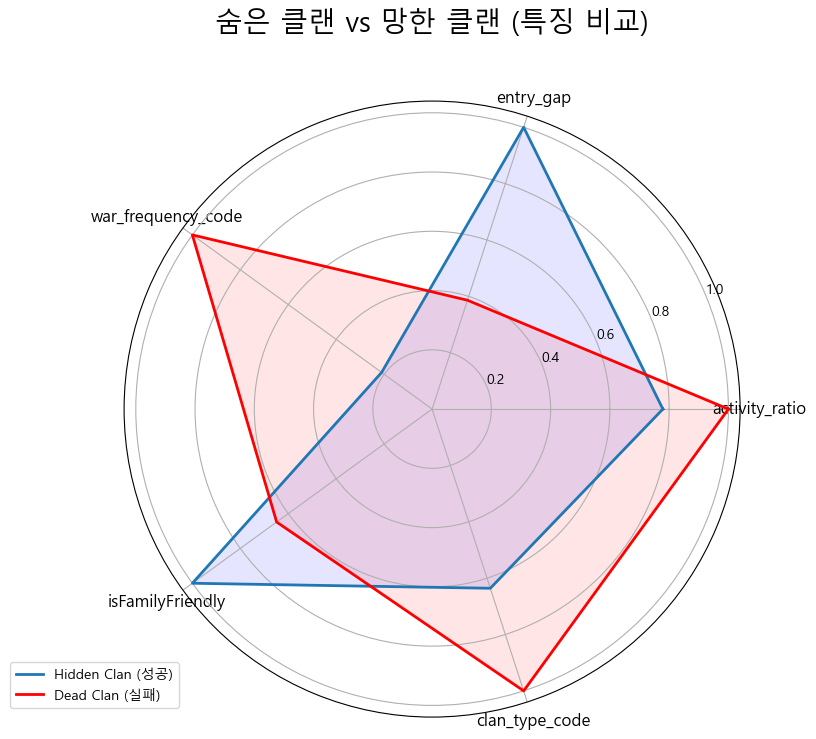

수치 비교:
                      Hidden Gem   Dead Clan
activity_ratio        17.724783   22.757305
entry_gap           1337.979982  516.861358
war_frequency_code     0.717647    3.410257
isFamilyFriendly       0.454960    0.295032
clan_type_code         1.159321    1.823281


In [116]:
import numpy as np
from math import pi

# 1. 비교군 데이터 준비
# (1) Hidden Gems (우리가 찾는 숨은 클랜) 평균
gem_stats = hidden_gems[engineered_features_v2].mean()

# (2) Dead Clans (비슷한 규모인데 망한 클랜들) 평균
# 조건: 멤버 5~15명인데 생존확률 하위 20%인 애들
dead_clans = target_small_clans[target_small_clans['success_prob'] < 0.2]
dead_stats = dead_clans[engineered_features_v2].mean()

# 2. 데이터 정규화 (MinMax Scaling) - 그래프 예쁘게 그리기 위함
merged_stats = pd.concat([gem_stats, dead_stats], axis=1)
merged_stats.columns = ['Hidden Gem', 'Dead Clan']
# 0~1 사이로 변환
normalized_stats = merged_stats.div(merged_stats.max(axis=1), axis=0)

# 3. 레이더 차트 그리기
def make_radar_chart(df, title):
    categories = df.index.tolist()
    N = len(categories)
    
    # 각도 계산
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # 첫 번째: Hidden Gem (파란색)
    values = df['Hidden Gem'].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label='Hidden Clan (성공)')
    ax.fill(angles, values, 'b', alpha=0.1)
    
    # 두 번째: Dead Clan (빨간색)
    values = df['Dead Clan'].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', color='red', label='Dead Clan (실패)')
    ax.fill(angles, values, 'r', alpha=0.1)
    
    # 라벨 설정
    plt.xticks(angles[:-1], categories, size=12)
    plt.title(title, size=20, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

make_radar_chart(normalized_stats, "숨은 클랜 vs 망한 클랜 (특징 비교)")
print("수치 비교:\n", merged_stats)

In [118]:
import joblib

# 1. 모델 저장 (pickle 형태)
joblib.dump(lgbm_v2, 'clan_retention_model.pkl')

# 2. LabelEncoder도 저장 (war_frequency 변환에 필요)
joblib.dump(le, 'war_frequency_encoder.pkl')
# clan_type 인코더도 저장
joblib.dump(le_clan_type, 'clan_type_encoder.pkl')

print("모델 및 인코더 저장 완료!")
print("생성된 파일: clan_retention_model.pkl, war_frequency_encoder.pkl, clan_type_encoder.pkl")

모델 및 인코더 저장 완료!
생성된 파일: clan_retention_model.pkl, war_frequency_encoder.pkl, clan_type_encoder.pkl
